In [13]:
#! /usr/bin/env python3

import rospy
from sensor_msgs.msg import Image
from cv_bridge import CvBridge, CvBridgeError
from std_msgs.msg import Bool, String
import cv2
import numpy as np
from collections import Counter
import re
from datetime import datetime
import matplotlib.pyplot as plt

In [44]:
img2 = cv2.imread('template_full.png', cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread("debug_circled_image_2025-03-28_15-45-13.png", cv2.IMREAD_GRAYSCALE)

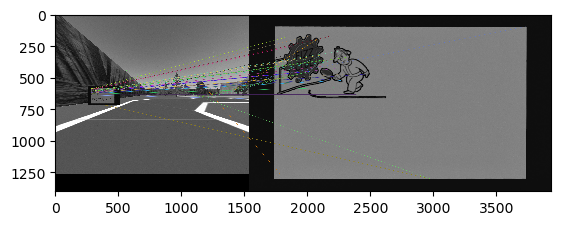

In [45]:
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

if len(good_matches) < 4:
    raise ValueError("Not enough good matches to compute perspective transform")

src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

h, w = img2.shape
aligned_img = cv2.warpPerspective(img1, M, (w, h))

img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img_matches)

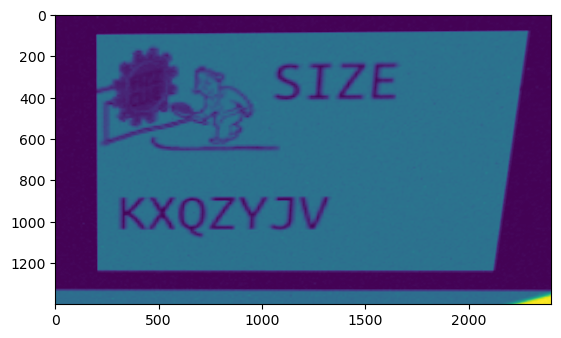

In [46]:
plt.imshow(aligned_img)

In [4]:
SIFT_IMAGE_HEIGHT = 1264
SIFT_IMAGE_WIDTH = 1536
SIFT_TEMPLATE_SCALE = 0.4
BLUE_THRESHOLD_PERCENTAGE = 0.55
MIN_MATCH_COUNT = 20

In [50]:
sift = cv2.SIFT_create()
index_params = dict(algorithm=0, trees=5)
search_params = dict()
flann = cv2.FlannBasedMatcher(index_params, search_params)
template_img = cv2.imread("template_full.png", cv2.IMREAD_GRAYSCALE)
template_img_small = cv2.resize(template_img, None, fx=SIFT_TEMPLATE_SCALE, fy=SIFT_TEMPLATE_SCALE, interpolation=cv2.INTER_AREA)
template_kp, template_des = sift.detectAndCompute(template_img_small, None)

In [51]:
image = cv2.imread("debug_circled_image_2025-03-28_15-45-13.png")
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kp, des = sift.detectAndCompute(image_gray, None)

In [53]:
print(image.shape)
print(template_img.shape, template_img_small.shape)

(1264, 1536, 3)
(1400, 2400) (560, 960)


In [66]:
matches = flann.knnMatch(des, template_des, k=2)
good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

In [67]:
src_pts = np.float32([kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([template_kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

In [73]:
S_image = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]], dtype = np.float32
)

S_template_inv = np.array([
    [1/SIFT_TEMPLATE_SCALE, 0, 0],
    [0, 1/SIFT_TEMPLATE_SCALE, 0],
    [0, 0, 1]], dtype = np.float32
)
H_S = S_template_inv @ H @ S_image

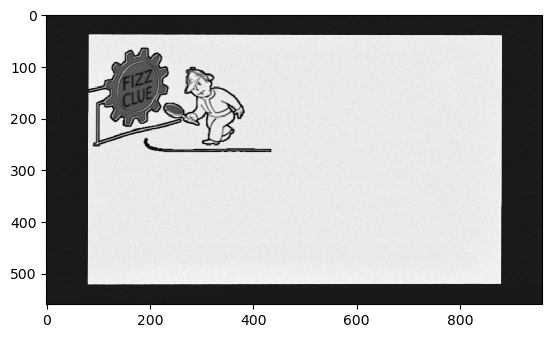

In [27]:
plt.imshow(template_img_small, cmap='gray')

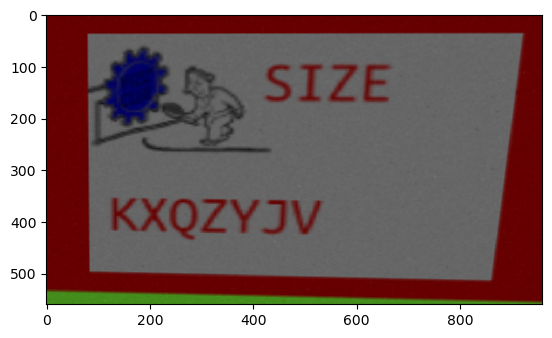

In [72]:
warped_image = cv2.warpPerspective(image, H, (template_img_small.shape[1], template_img_small.shape[0]))
plt.imshow(warped_image)

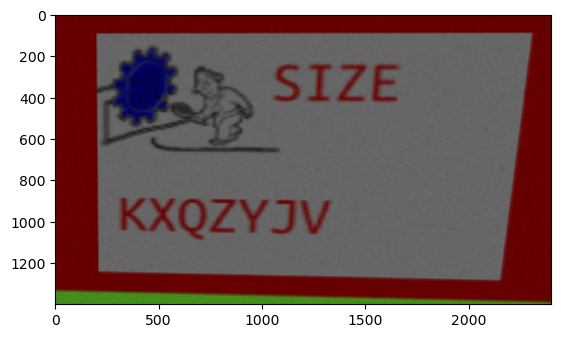

In [74]:
warped_image = cv2.warpPerspective(image, H_S, (template_img.shape[1], template_img.shape[0]))
plt.imshow(warped_image)

In [ ]:
try:
            rospy.loginfo("Step 1: Running SIFT and computing homography...")
            image_small = cv2.resize(image, (SIFT_IMAGE_WIDTH, SIFT_IMAGE_HEIGHT))
            rospy.loginfo(f"Resized image to: {image_small.shape}")
            image_gray = cv2.cvtColor(image_small, cv2.COLOR_BGR2GRAY)
            kp, des = self.sift.detectAndCompute(image_gray, None)

            if des is None or len(kp) == 0:
                rospy.logwarn("No keypoints/descriptors found in the input image. Skipping.")
                return

            rospy.loginfo(f"Found {len(kp)} keypoints in image.")
            matches = self.flann.knnMatch(self.template_des, des, k=2)
            good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
            rospy.loginfo(f"Found {len(good_matches)} good matches.")

            if len(good_matches) <= MIN_MATCH_COUNT:
                rospy.logwarn(f"Not enough matches ({len(good_matches)}) to compute homography. Skipping image.")
                return

            src_pts = np.float32([self.template_kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            if H is None:
                rospy.logwarn("Homography could not be computed. Skipping image.")
                return
            
             # warps the sign found in the image to the template size (1400x2400)
            S_image = np.array([
                [1, 0, 0],
                [0, 1, 0],
                [0, 0, 1]
            ])

            S_template_inv = np.array([
                [1/SIFT_TEMPLATE_SCALE, 0, 0],
                [0, 1/SIFT_TEMPLATE_SCALE, 0],
                [0, 0, 1]
            ])
            H_S = S_template_inv @ H @ S_image

            rospy.loginfo("Homography matrix computed successfully.")
            warped_image = cv2.warpPerspective(image, H_S, (self.template_img.shape[1], self.template_img.shape[0]))
            rospy.loginfo(f"Warped image shape: {warped_image.shape}")

        except Exception as e:
            rospy.logerr(f"Exception during SIFT/homography: {e}")
            return
        
        # cv2.imshow("warped_image", warped_image)
        # cv2.waitKey(1)
        cv2.imwrite(f"/home/fizzer/ros_ws/training_for_driving/debug_warped_image{warped_image[40][40]}.png", warped_image)
        rospy.loginfo("Saved warped image")

        try:
            rospy.loginfo("Step 2: Thresholding and cropping characters...")
            blue_mask = self.blue_threshold(warped_image)
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
            mask_cleaned = cv2.morphologyEx(blue_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
            rospy.loginfo("Morphological cleaning complete.")

            border_check = [mask_cleaned[10, 10], mask_cleaned[10, -10], mask_cleaned[-10, 10], mask_cleaned[-10, -10]]
            rospy.loginfo(f"Corner pixels: {border_check}")
            if all(val == 255 for val in border_check):
                rospy.loginfo("Border appears complete.")
            else:
                rospy.logwarn("Border is incomplete. Continuing anyway...")

            flood_filled = mask_cleaned.copy()
            cv2.floodFill(flood_filled, None, (14, 14), 0)
            rospy.loginfo("Flood fill complete.")

            num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(flood_filled, connectivity=4)
            rospy.loginfo(f"Found {num_labels - 1} connected components.")

            letter_boxes = []
            for i in range(1, num_labels):
                x, y, w, h, area = stats[i]
                if area > 300:
                    letter_boxes.append((x, y, w, h))
            rospy.loginfo(f"{len(letter_boxes)} letter boxes after area filter.")

            img_height = flood_filled.shape[0]
            top_half, bottom_half = [], []
            for box in letter_boxes:
                x, y, w, h = box
                if y + h / 2 < img_height / 2:
                    top_half.append(box)
                else:
                    bottom_half.append(box)

            top_half = sorted(top_half, key=lambda b: b[0])
            bottom_half = sorted(bottom_half, key=lambda b: b[0])
            rospy.loginfo(f"Top boxes: {len(top_half)}, Bottom boxes: {len(bottom_half)}")

            def crop_or_pad_box(letter_boxes):
                target_width = 200
                target_height = 240
                crops = []
                for (x, y, w, h) in letter_boxes:
                    crop = flood_filled[y:y + h, x:x + w]
                    crop = cv2.resize(crop, (min(w, target_width), min(h, target_height)), interpolation=cv2.INTER_AREA)
                    h2, w2 = crop.shape
                    pad_top = (target_height - h2) // 2
                    pad_bottom = target_height - h2 - pad_top
                    pad_left = (target_width - w2) // 2
                    pad_right = target_width - w2 - pad_left
                    padded = cv2.copyMakeBorder(
                        crop, pad_top, pad_bottom, pad_left, pad_right,
                        borderType=cv2.BORDER_CONSTANT, value=0
                    )
                    crops.append(padded)
                return crops

            top_half_crops = crop_or_pad_box(top_half)
            bottom_half_crops = crop_or_pad_box(bottom_half)

            circled_image = cv2.cvtColor(flood_filled, cv2.COLOR_GRAY2BGR)
            for (x, y, w, h) in (top_half + bottom_half):
                cv2.rectangle(circled_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

            
            rospy.loginfo("Saved circled image")
            # cv2.imshow("flood filled image", circled_image)
            # cv2.waitKey(1)

        except Exception as e:
            rospy.logerr(f"Exception during thresholding/cropping: {e}")
            return

        try:
            rospy.loginfo("Step 3: Publishing characters to CNN classification topic...")
            self.sign_index += 1
            self.top_words.append(['*'] * len(top_half_crops))
            self.bottom_words.append(['*'] * len(bottom_half_crops))

            for i, image in enumerate(top_half_crops):
                image = image.astype(np.float32) / 255.0
                ros_image = self.bridge.cv2_to_imgmsg(image, encoding='32FC1')
                msg = ImageWithID()
                msg.id = f"{self.sign_index}t{i}"
                msg.image = ros_image
                self.pub_read.publish(msg)
                rospy.loginfo(f"Published top image ID: {msg.id}")

            for i, image in enumerate(bottom_half_crops):
                image = image.astype(np.float32) / 255.0
                ros_image = self.bridge.cv2_to_imgmsg(image, encoding='32FC1')
                msg = ImageWithID()
                msg.id = f"{self.sign_index}b{i}"
                msg.image = ros_image
                self.pub_read.publish(msg)
                rospy.loginfo(f"Published bottom image ID: {msg.id}")

            rospy.loginfo("Finished publishing all character crops.")

        except Exception as e:
            rospy.logerr(f"Exception during CNN classification/publishing: {e}")